In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

from causal_meta.utils import train_utils as tu
from encoder import Rotor
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [4]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

## Utilities

In [5]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

def normal_like(X): 
    mean = X.mean()
    std = X.std()
    return normal(mean, std, X.size(0))

def mlp(opt): 
    if opt.NUM_MID_LAYERS == -1: 
        return nn.Linear(opt.INP_DIM, opt.OUT_DIM)
    else:
        return nets.MLP(opt.INP_DIM, opt.OUT_DIM, opt.NUM_MID_LAYERS, 
                        opt.CAPACITY, opt.INP_NOISE)

## Mixture Density

In [6]:
def mdn(opt): 
    return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

## Reversible Encoder

In [7]:
def xcodergen(opt): 
    # Make rotor
    return Rotor(opt.XCODER_INIT)

## Ground Truth Generator

We use a posterior of the form: 

$$
P(Y | X) = \sum_i \pi_i(X) \mathcal{N}(\mu_i(X), \sigma_i(X))
$$

which is a mixture of 10 gaussians. 

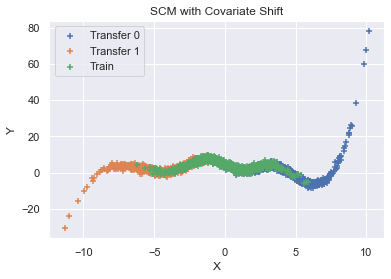

In [8]:
# Test
rand_scm = RandomSplineSCM(False, True, 8, 8, 3, range_scale=1.)

plt.figure()
plt.title("SCM with Covariate Shift")
rand_scm.plot(X=normal(4, 2, 1000), show=False, label='Transfer 0')
rand_scm.plot(X=normal(-4, 2, 1000), show=False, label='Transfer 1')
rand_scm.plot(X=normal(0, 2, 1000), show=False, label='Train')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Visualization

In [9]:
def plot_key(frames, key, show=True, label=None, name=None): 
    its, vals = zip(*[(frame.iter_num, getattr(frame, key)) for frame in frames])
    if show:
        plt.figure()
    plt.plot(its, vals, label=label)
    if show:
        plt.xlabel("Iterations")
        plt.ylabel(name if name is not None else key.title())
        plt.show()

## Training

In [10]:
def gradnan_filter(model): 
    nan_found = False
    for p in model.parameters(): 
        nan_mask = torch.isnan(p.grad.data)
        nan_found = bool(nan_mask.any().item())
        p.grad.data[nan_mask] = 0.
    return nan_found

In [11]:
def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp, n_iter=opt.EM_ITERS)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

In [70]:
def encoder_train_shared_regret(opt, model_x2y, model_y2x, scm, encoder, decoder, alpha): 
    theta = nn.Parameter(torch.tensor(0.01).to('cuda' if opt.CUDA else 'cpu'))
    if opt.CUDA: 
        model_x2y = model_x2y.cuda()
        model_y2x = model_y2x.cuda()
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    encoder_optim = torch.optim.Adam(encoder.parameters(), opt.ENCODER_LR)
    alpha_optim = torch.optim.Adam([alpha], opt.ALPHA_LR)
    theta_optim = torch.optim.Adam([theta], opt.ALPHA_LR)
    frames = []
    for meta_iter in tqdm.trange(opt.NUM_META_ITER): 
        # Preheat the models
        _ = tu.train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, 'X2Y', 
                         mdn_nll, decoder, encoder)
        _ = tu.train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, 'Y2X', 
                         mdn_nll, decoder, encoder)
        # Sample from SCM
        X = opt.TRANS_DISTRY()
        Y = scm(X)
        if opt.CUDA: 
            X, Y = X.cuda(), Y.cuda()
        # Decode 
        with torch.no_grad(): 
            X, Y = decoder(X, Y)
        # Encode
        X, Y = encoder(X, Y)
        X_test = X[opt.NUM_MAML_SAMPLES:, :]
        Y_test = Y[opt.NUM_MAML_SAMPLES:, :]
        X = X[:opt.NUM_MAML_SAMPLES, :]
        Y = Y[:opt.NUM_MAML_SAMPLES, :]
        
        with torch.no_grad():
            if opt.USE_BASELINE:
                baseline_y = marginal_nll(opt, Y, mdn_nll)
                baseline_x = marginal_nll(opt, X, mdn_nll)
            else:
                baseline_y = 0.
                baseline_x = 0.
        # Save state dicts
        state_x2y = deepcopy(model_x2y.state_dict())
        state_y2x = deepcopy(model_y2x.state_dict())
        # Inner loop 
        #optim_x2y = torch.optim.Adam(model_x2y.parameters(), lr=opt.FINETUNE_LR)
        #optim_y2x = torch.optim.Adam(model_y2x.parameters(), lr=opt.FINETUNE_LR)
        regrets_x2y = []
        regrets_y2x = []
        is_nan = False
        
        
        # Evaluate regret discrepancy 
        # First step
        loss_x2y = mdn_nll(model_x2y(X), Y)
        loss_y2x = mdn_nll(model_y2x(Y), X)
        if torch.isnan(loss_x2y).item() or torch.isnan(loss_y2x).item(): 
            is_nan = True
            break
        grad_x2y = torch.autograd.grad(loss_x2y, model_x2y.parameters())
        grad_y2x = torch.autograd.grad(loss_y2x, model_y2x.parameters())
        # Filter out NaNs that might have sneaked in
        nan_in_x2y = gradnan_filter(model_x2y)
        nan_in_y2x = gradnan_filter(model_y2x)
        if nan_in_x2y or nan_in_y2x: 
            is_nan = True
            break
        fast_weights_x2y = list(map(lambda p: p[1] - theta * p[0], zip(grad_x2y, model_x2y.parameters())))
        fast_weights_y2x = list(map(lambda p: p[1] - theta * p[0], zip(grad_y2x, model_y2x.parameters())))
        # Store for encoder
        
        for t in range(1, opt.FINETUNE_MAML_NUM_ITER):
            model_x2y.load_state_dict({x: y for x, y in zip(list(model_x2y.state_dict().keys()), fast_weights_x2y)})
            model_y2x.load_state_dict({x: y for x, y in zip(list(model_y2x.state_dict().keys()), fast_weights_y2x)})
            
            loss_x2y = mdn_nll(model_x2y(X), Y)
            loss_y2x = mdn_nll(model_y2x(Y), X)
            if torch.isnan(loss_x2y).item() or torch.isnan(loss_y2x).item(): 
                is_nan = True
                break
            grad_x2y = torch.autograd.grad(loss_x2y, model_x2y.parameters())
            grad_y2x = torch.autograd.grad(loss_y2x, model_y2x.parameters())
            #optim_x2y.zero_grad()
            #optim_y2x.zero_grad()
            #loss_x2y.backward(retain_graph=True) 
            #loss_y2x.backward(retain_graph=True)
            # Filter out NaNs that might have sneaked in
            nan_in_x2y = gradnan_filter(model_x2y)
            nan_in_y2x = gradnan_filter(model_y2x)
            if nan_in_x2y or nan_in_y2x: 
                is_nan = True
                break
            #optim_x2y.step()
            #optim_y2x.step()
            fast_weights_x2y = list(map(lambda p: p[1] - theta * p[0], zip(grad_x2y, model_x2y.parameters())))
            fast_weights_y2x = list(map(lambda p: p[1] - theta * p[0], zip(grad_y2x, model_y2x.parameters())))
            # Store for encoder
        model_x2y.load_state_dict({x: y for x, y in zip(list(model_x2y.state_dict().keys()), fast_weights_x2y)})
        model_y2x.load_state_dict({x: y for x, y in zip(list(model_y2x.state_dict().keys()), fast_weights_y2x)})
            
        for t in range(opt.FINETUNE_NUM_ITER):
            loss_x2y = mdn_nll(model_x2y(X_test), Y_test)
            loss_y2x = mdn_nll(model_y2x(Y_test), X_test)
            regrets_x2y.append(loss_x2y + baseline_x)
            regrets_y2x.append(loss_y2x + baseline_y)
        if not is_nan:
            # Evaluate total regret
            regret_x2y = torch.stack(regrets_x2y).mean()
            regret_y2x = torch.stack(regrets_y2x).mean()
            # Evaluate losses
            loss = torch.logsumexp(
                torch.stack([F.logsigmoid(alpha) + regret_x2y,
                             F.logsigmoid(-alpha) + regret_y2x]), 
                0)
            # Optimize
            encoder_optim.zero_grad()
            alpha_optim.zero_grad()
            theta_optim.zero_grad()
            loss.backward()
            # Make sure no nans
            if torch.isnan(encoder.theta.grad.data).any(): 
                encoder.theta.grad.data.zero_()
            if torch.isnan(alpha.grad.data).any(): 
                alpha.grad.data.zero_()
            encoder_optim.step()
            alpha_optim.step()
            theta_optim.step()
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=regret_x2y.item(), 
                                    regret_y2x=regret_y2x.item(),
                                    loss=loss.item(),
                                    alpha=alpha.item(), 
                                    theta=encoder.theta.item()))
        else:
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add dummy info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=float('nan'), 
                                    regret_y2x=float('nan'),
                                    loss=float('nan'),
                                    alpha=float('nan'), 
                                    theta=float('nan')))
            
    return frames

In [13]:
def plot_theta(frames, gt_theta, save=False): 
    its, vals = zip(*[(frame.iter_num, frame.theta / (np.pi / 2)) for frame in frames])
    gt_theta = -gt_theta.item() / (np.pi / 2)
    plt.figure()
    # plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$', c='black')
    plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$')
    plt.plot(its, [gt_theta] * len(its), linestyle='--', label=r'Solution 1 $\left(+\frac{\pi}{4}\right)$')
    plt.plot(its, [gt_theta - 1] * len(its), linestyle='--', label=r'Solution 2 $\left(-\frac{\pi}{4}\right)$')
    plt.xlabel("Iterations")
    plt.ylabel("Encoder Angle [π/2 rad]")
    plt.legend()
    if save:
        plt.savefig('fixed-encoder-evo.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [14]:
def probe_xcoders(encoder, decoder):
    # Test encoder and decoder
    with torch.no_grad():
        _X = torch.tensor([[1.]])
        _Y = torch.tensor([[0.]])
        if opt.CUDA:
            _X, _Y = _X.to(encoder.theta.device), _Y.to(encoder.theta.device)
        _X_d, _Y_d = decoder(_X, _Y)
        _X_de, _Y_de = encoder(_X_d, _Y_d)
    print(f"Initial (A, B) = {_X.item()}, {_Y.item()}")
    print(f"Decoded (X, Y) = {_X_d.item()}, {_Y_d.item()}")
    print(f"Encoded (U, V) = {_X_de.item()}, {_Y_de.item()}")

# Experiments with Unfixed Encoders

In [74]:
opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10

# Training
opt.LR = 0.01
opt.NUM_ITER = 20
opt.NUM_META_ITER = 1000
opt.ENCODER_LR = 0.01
opt.ALPHA_LR = 0.001
opt.CUDA = False #sTrue
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_MAML_NUM_ITER = 1
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 500

# Sampling 
opt.NUM_SAMPLES = 100
opt.NUM_MAML_SAMPLES = 100
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_MAML_SAMPLES + opt.NUM_SAMPLES)

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

## Make Xcoders

Make a ground-truth decoder with $\theta_0$. 

In [75]:
gt_decoder = Rotor(opt.DECODER_DEFAULT)

The real encoder should have $\theta = -\theta_0$. 

In [76]:
encoder = Rotor(0. * np.pi/2)

In [77]:
probe_xcoders(encoder, gt_decoder)

Initial (A, B) = 1.0, 0.0
Decoded (X, Y) = 0.7071067690849304, 0.7071067690849304
Encoded (U, V) = 0.7071067690849304, 0.7071067690849304


## Make Alpha and Models

In [78]:
alpha = tu.make_alpha(opt)

In [79]:
model_x2y = mdn(opt)
model_y2x = mdn(opt)

## Train Encoder

If it doesn't work with the seed of your choice, try tuning the (hyper)parameters of ```opt.TRANS_DISTRY```. Since the SCM is generated randomly, it's not possible to know the correct hyper-parameters in advance (unless the seed is fixed). $\sigma \in (1, 2)$ should work fine, but if the range from which the means are sampled is too large, you can have numerical instabilities. If it's too small, the gradient signal to the encoder can be weak. 

In [80]:
frames = encoder_train_shared_regret(opt, model_x2y, model_y2x, rand_scm, encoder, gt_decoder, alpha)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:28,  1.96it/s]

  0%|          | 2/1000 [00:00<08:18,  2.00it/s]

  0%|          | 3/1000 [00:01<07:52,  2.11it/s]

  0%|          | 4/1000 [00:01<07:19,  2.27it/s]

  0%|          | 5/1000 [00:02<06:49,  2.43it/s]

  1%|          | 6/1000 [00:02<07:09,  2.31it/s]

  1%|          | 7/1000 [00:02<06:48,  2.43it/s]

  1%|          | 8/1000 [00:03<06:59,  2.37it/s]

  1%|          | 9/1000 [00:03<07:06,  2.32it/s]

  1%|          | 10/1000 [00:04<07:04,  2.33it/s]

  1%|          | 11/1000 [00:04<07:02,  2.34it/s]

  1%|          | 12/1000 [00:05<07:51,  2.09it/s]

  1%|▏         | 13/1000 [00:05<08:07,  2.03it/s]

  1%|▏         | 14/1000 [00:06<07:59,  2.05it/s]

  2%|▏         | 15/1000 [00:06<07:53,  2.08it/s]

  2%|▏         | 16/1000 [00:07<10:36,  1.55it/s]

  2%|▏         | 17/1000 [00:08<11:10,  1.47it/s]

  2%|▏         | 18/1000 [00:09<13:10,  1.24it/s]

  2%|▏         | 19/1000 [00:10<13:07,  1.24it/s]

  2%|▏         | 20/1000 [00:11<13:14,  1.23it/s]

  2%|▏         | 21/1000 [00:12<13:39,  1.19it/s]

  2%|▏         | 22/1000 [00:13<16:28,  1.01s/it]

  2%|▏         | 23/1000 [00:14<16:27,  1.01s/it]

  2%|▏         | 24/1000 [00:15<16:15,  1.00it/s]

  2%|▎         | 25/1000 [00:17<18:28,  1.14s/it]

  3%|▎         | 26/1000 [00:17<16:38,  1.02s/it]

  3%|▎         | 27/1000 [00:18<13:18,  1.22it/s]

  3%|▎         | 28/1000 [00:18<11:39,  1.39it/s]

  3%|▎         | 29/1000 [00:19<11:05,  1.46it/s]

  3%|▎         | 30/1000 [00:19<10:37,  1.52it/s]

  3%|▎         | 31/1000 [00:20<10:58,  1.47it/s]

  3%|▎         | 32/1000 [00:21<10:40,  1.51it/s]

  3%|▎         | 33/1000 [00:21<09:48,  1.64it/s]

  3%|▎         | 34/1000 [00:22<10:14,  1.57it/s]

  4%|▎         | 35/1000 [00:22<09:09,  1.76it/s]

  4%|▎         | 36/1000 [00:23<08:47,  1.83it/s]

  4%|▎         | 37/1000 [00:23<08:34,  1.87it/s]

  4%|▍         | 38/1000 [00:24<09:05,  1.76it/s]

  4%|▍         | 39/1000 [00:24<07:51,  2.04it/s]

  4%|▍         | 40/1000 [00:25<07:45,  2.06it/s]

  4%|▍         | 41/1000 [00:25<07:34,  2.11it/s]

  4%|▍         | 42/1000 [00:26<07:38,  2.09it/s]

  4%|▍         | 43/1000 [00:26<07:09,  2.23it/s]

  4%|▍         | 44/1000 [00:27<09:56,  1.60it/s]

  4%|▍         | 45/1000 [00:28<09:11,  1.73it/s]

  5%|▍         | 46/1000 [00:28<08:59,  1.77it/s]

  5%|▍         | 47/1000 [00:29<09:01,  1.76it/s]

  5%|▍         | 48/1000 [00:29<08:17,  1.92it/s]

  5%|▍         | 49/1000 [00:29<07:49,  2.03it/s]

  5%|▌         | 50/1000 [00:30<07:34,  2.09it/s]

  5%|▌         | 51/1000 [00:30<07:26,  2.13it/s]

  5%|▌         | 52/1000 [00:31<07:18,  2.16it/s]

  5%|▌         | 53/1000 [00:31<07:03,  2.24it/s]

  5%|▌         | 54/1000 [00:32<07:05,  2.22it/s]

  6%|▌         | 55/1000 [00:32<06:55,  2.27it/s]

  6%|▌         | 56/1000 [00:33<06:53,  2.28it/s]

  6%|▌         | 57/1000 [00:33<07:06,  2.21it/s]

  6%|▌         | 58/1000 [00:33<07:06,  2.21it/s]

  6%|▌         | 59/1000 [00:34<06:24,  2.44it/s]

  6%|▌         | 60/1000 [00:34<06:34,  2.38it/s]

  6%|▌         | 61/1000 [00:35<06:48,  2.30it/s]

  6%|▌         | 62/1000 [00:35<06:27,  2.42it/s]

  6%|▋         | 63/1000 [00:36<06:40,  2.34it/s]

  6%|▋         | 64/1000 [00:36<06:19,  2.47it/s]

  6%|▋         | 65/1000 [00:36<05:52,  2.66it/s]

  7%|▋         | 66/1000 [00:37<06:39,  2.34it/s]

  7%|▋         | 67/1000 [00:37<06:48,  2.28it/s]

  7%|▋         | 68/1000 [00:38<07:33,  2.06it/s]

  7%|▋         | 69/1000 [00:38<06:59,  2.22it/s]

  7%|▋         | 70/1000 [00:39<07:27,  2.08it/s]

  7%|▋         | 71/1000 [00:39<07:02,  2.20it/s]

  7%|▋         | 72/1000 [00:40<07:08,  2.17it/s]

  7%|▋         | 73/1000 [00:40<07:10,  2.15it/s]

  7%|▋         | 74/1000 [00:40<06:51,  2.25it/s]

  8%|▊         | 75/1000 [00:41<06:52,  2.24it/s]

  8%|▊         | 76/1000 [00:41<06:46,  2.27it/s]

  8%|▊         | 77/1000 [00:42<07:03,  2.18it/s]

  8%|▊         | 78/1000 [00:42<06:37,  2.32it/s]

  8%|▊         | 79/1000 [00:43<06:49,  2.25it/s]

  8%|▊         | 80/1000 [00:43<06:53,  2.23it/s]

  8%|▊         | 81/1000 [00:44<06:47,  2.25it/s]

  8%|▊         | 82/1000 [00:44<08:13,  1.86it/s]

  8%|▊         | 83/1000 [00:45<10:13,  1.50it/s]

  8%|▊         | 84/1000 [00:46<10:15,  1.49it/s]

  8%|▊         | 85/1000 [00:47<09:54,  1.54it/s]

  9%|▊         | 86/1000 [00:47<09:54,  1.54it/s]

  9%|▊         | 87/1000 [00:48<09:03,  1.68it/s]

  9%|▉         | 88/1000 [00:48<08:09,  1.86it/s]

  9%|▉         | 89/1000 [00:49<07:58,  1.90it/s]

  9%|▉         | 90/1000 [00:49<07:50,  1.94it/s]

  9%|▉         | 91/1000 [00:50<07:39,  1.98it/s]

  9%|▉         | 92/1000 [00:50<07:24,  2.04it/s]

  9%|▉         | 93/1000 [00:50<06:35,  2.29it/s]

  9%|▉         | 94/1000 [00:51<08:09,  1.85it/s]

 10%|▉         | 95/1000 [00:52<11:14,  1.34it/s]

 10%|▉         | 96/1000 [00:53<11:56,  1.26it/s]

 10%|▉         | 97/1000 [00:54<13:17,  1.13it/s]

 10%|▉         | 98/1000 [00:55<13:30,  1.11it/s]

 10%|▉         | 99/1000 [00:57<17:24,  1.16s/it]

 10%|█         | 100/1000 [00:58<16:09,  1.08s/it]

 10%|█         | 101/1000 [00:59<14:40,  1.02it/s]

 10%|█         | 102/1000 [00:59<13:40,  1.09it/s]

 10%|█         | 103/1000 [01:00<12:37,  1.18it/s]

 10%|█         | 104/1000 [01:01<11:37,  1.29it/s]

 10%|█         | 105/1000 [01:01<11:25,  1.31it/s]

 11%|█         | 106/1000 [01:02<12:02,  1.24it/s]

 11%|█         | 107/1000 [01:03<12:18,  1.21it/s]

 11%|█         | 108/1000 [01:04<11:24,  1.30it/s]

 11%|█         | 109/1000 [01:04<10:44,  1.38it/s]

 11%|█         | 110/1000 [01:05<10:36,  1.40it/s]

 11%|█         | 111/1000 [01:06<10:16,  1.44it/s]

 11%|█         | 112/1000 [01:06<10:04,  1.47it/s]

 11%|█▏        | 113/1000 [01:07<09:18,  1.59it/s]

 11%|█▏        | 114/1000 [01:08<09:14,  1.60it/s]

 12%|█▏        | 115/1000 [01:08<08:32,  1.73it/s]

 12%|█▏        | 116/1000 [01:09<08:37,  1.71it/s]

 12%|█▏        | 117/1000 [01:09<08:10,  1.80it/s]

 12%|█▏        | 118/1000 [01:10<08:09,  1.80it/s]

 12%|█▏        | 119/1000 [01:10<08:01,  1.83it/s]

 12%|█▏        | 120/1000 [01:11<08:04,  1.82it/s]

 12%|█▏        | 121/1000 [01:11<08:09,  1.79it/s]

 12%|█▏        | 122/1000 [01:12<07:35,  1.93it/s]

 12%|█▏        | 123/1000 [01:12<06:55,  2.11it/s]

 12%|█▏        | 124/1000 [01:13<06:55,  2.11it/s]

 12%|█▎        | 125/1000 [01:13<06:54,  2.11it/s]

 13%|█▎        | 126/1000 [01:14<06:56,  2.10it/s]

 13%|█▎        | 127/1000 [01:14<06:52,  2.12it/s]

 13%|█▎        | 128/1000 [01:14<06:27,  2.25it/s]

 13%|█▎        | 129/1000 [01:15<06:32,  2.22it/s]

 13%|█▎        | 130/1000 [01:15<06:45,  2.15it/s]

 13%|█▎        | 131/1000 [01:16<06:44,  2.15it/s]

 13%|█▎        | 132/1000 [01:16<06:43,  2.15it/s]

 13%|█▎        | 133/1000 [01:17<06:48,  2.12it/s]

 13%|█▎        | 134/1000 [01:17<06:35,  2.19it/s]

 14%|█▎        | 135/1000 [01:18<06:32,  2.20it/s]

 14%|█▎        | 136/1000 [01:18<06:16,  2.30it/s]

 14%|█▎        | 137/1000 [01:18<06:06,  2.35it/s]

 14%|█▍        | 138/1000 [01:19<05:57,  2.41it/s]

 14%|█▍        | 139/1000 [01:19<06:07,  2.34it/s]

 14%|█▍        | 140/1000 [01:20<06:27,  2.22it/s]

 14%|█▍        | 141/1000 [01:20<06:07,  2.34it/s]

 14%|█▍        | 142/1000 [01:21<05:56,  2.41it/s]

 14%|█▍        | 143/1000 [01:21<06:12,  2.30it/s]

 14%|█▍        | 144/1000 [01:22<06:21,  2.25it/s]

 14%|█▍        | 145/1000 [01:22<06:33,  2.17it/s]

 15%|█▍        | 146/1000 [01:23<06:31,  2.18it/s]

 15%|█▍        | 147/1000 [01:23<06:36,  2.15it/s]

 15%|█▍        | 148/1000 [01:23<06:22,  2.23it/s]

 15%|█▍        | 149/1000 [01:24<06:21,  2.23it/s]

 15%|█▌        | 150/1000 [01:24<06:37,  2.14it/s]

 15%|█▌        | 151/1000 [01:25<06:42,  2.11it/s]

 15%|█▌        | 152/1000 [01:25<06:32,  2.16it/s]

 15%|█▌        | 153/1000 [01:26<06:25,  2.19it/s]

 15%|█▌        | 154/1000 [01:26<06:34,  2.14it/s]

 16%|█▌        | 155/1000 [01:27<06:34,  2.14it/s]

 16%|█▌        | 156/1000 [01:27<06:35,  2.13it/s]

 16%|█▌        | 157/1000 [01:28<06:31,  2.15it/s]

 16%|█▌        | 158/1000 [01:28<06:20,  2.22it/s]

 16%|█▌        | 159/1000 [01:29<06:33,  2.13it/s]

 16%|█▌        | 160/1000 [01:29<06:39,  2.11it/s]

 16%|█▌        | 161/1000 [01:29<06:03,  2.31it/s]

 16%|█▌        | 162/1000 [01:30<07:32,  1.85it/s]

 16%|█▋        | 163/1000 [01:31<08:16,  1.69it/s]

 16%|█▋        | 164/1000 [01:31<07:44,  1.80it/s]

 16%|█▋        | 165/1000 [01:32<06:58,  2.00it/s]

 17%|█▋        | 166/1000 [01:32<06:19,  2.20it/s]

 17%|█▋        | 167/1000 [01:32<05:30,  2.52it/s]

 17%|█▋        | 168/1000 [01:33<05:14,  2.65it/s]

 17%|█▋        | 169/1000 [01:33<05:43,  2.42it/s]

 17%|█▋        | 170/1000 [01:34<05:57,  2.32it/s]

 17%|█▋        | 171/1000 [01:34<05:45,  2.40it/s]

 17%|█▋        | 172/1000 [01:35<06:08,  2.25it/s]

 17%|█▋        | 173/1000 [01:35<06:00,  2.29it/s]

 17%|█▋        | 174/1000 [01:35<06:06,  2.25it/s]

 18%|█▊        | 175/1000 [01:36<06:02,  2.28it/s]

 18%|█▊        | 176/1000 [01:36<06:09,  2.23it/s]

 18%|█▊        | 177/1000 [01:37<06:15,  2.19it/s]

 18%|█▊        | 178/1000 [01:37<06:07,  2.24it/s]

 18%|█▊        | 179/1000 [01:38<05:39,  2.42it/s]

 18%|█▊        | 180/1000 [01:38<05:56,  2.30it/s]

 18%|█▊        | 181/1000 [01:38<06:04,  2.25it/s]

 18%|█▊        | 182/1000 [01:39<06:07,  2.22it/s]

 18%|█▊        | 183/1000 [01:39<05:52,  2.32it/s]

 18%|█▊        | 184/1000 [01:40<05:50,  2.33it/s]

 18%|█▊        | 185/1000 [01:40<05:27,  2.49it/s]

 19%|█▊        | 186/1000 [01:40<05:20,  2.54it/s]

 19%|█▊        | 187/1000 [01:41<05:41,  2.38it/s]

 19%|█▉        | 188/1000 [01:41<05:56,  2.28it/s]

 19%|█▉        | 189/1000 [01:42<05:48,  2.33it/s]

 19%|█▉        | 190/1000 [01:42<05:57,  2.26it/s]

 19%|█▉        | 191/1000 [01:43<06:14,  2.16it/s]

 19%|█▉        | 192/1000 [01:43<05:57,  2.26it/s]

 19%|█▉        | 193/1000 [01:44<06:45,  1.99it/s]

 19%|█▉        | 194/1000 [01:45<07:28,  1.80it/s]

 20%|█▉        | 195/1000 [01:45<07:08,  1.88it/s]

 20%|█▉        | 196/1000 [01:45<06:49,  1.97it/s]

 20%|█▉        | 197/1000 [01:46<06:18,  2.12it/s]

 20%|█▉        | 198/1000 [01:46<06:15,  2.14it/s]

 20%|█▉        | 199/1000 [01:47<06:19,  2.11it/s]

 20%|██        | 200/1000 [01:47<06:26,  2.07it/s]

 20%|██        | 201/1000 [01:48<06:07,  2.17it/s]

 20%|██        | 202/1000 [01:48<05:57,  2.23it/s]

 20%|██        | 203/1000 [01:49<05:44,  2.31it/s]

 20%|██        | 204/1000 [01:49<05:54,  2.25it/s]

 20%|██        | 205/1000 [01:49<05:44,  2.31it/s]

 21%|██        | 206/1000 [01:50<05:51,  2.26it/s]

 21%|██        | 207/1000 [01:50<05:59,  2.20it/s]

 21%|██        | 208/1000 [01:51<06:00,  2.20it/s]

 21%|██        | 209/1000 [01:51<05:47,  2.27it/s]

 21%|██        | 210/1000 [01:52<05:49,  2.26it/s]

 21%|██        | 211/1000 [01:52<06:00,  2.19it/s]

 21%|██        | 212/1000 [01:53<05:40,  2.31it/s]

 21%|██▏       | 213/1000 [01:53<05:22,  2.44it/s]

 21%|██▏       | 214/1000 [01:53<04:59,  2.63it/s]

 22%|██▏       | 215/1000 [01:54<05:19,  2.46it/s]

 22%|██▏       | 216/1000 [01:54<05:29,  2.38it/s]

 22%|██▏       | 217/1000 [01:55<05:32,  2.36it/s]

 22%|██▏       | 218/1000 [01:55<05:24,  2.41it/s]

 22%|██▏       | 219/1000 [01:55<05:19,  2.44it/s]

 22%|██▏       | 220/1000 [01:56<05:11,  2.50it/s]

 22%|██▏       | 221/1000 [01:56<04:44,  2.74it/s]

 22%|██▏       | 222/1000 [01:56<05:13,  2.49it/s]

 22%|██▏       | 223/1000 [01:57<05:30,  2.35it/s]

 22%|██▏       | 224/1000 [01:58<06:11,  2.09it/s]

 22%|██▎       | 225/1000 [01:58<06:14,  2.07it/s]

 23%|██▎       | 226/1000 [01:59<07:01,  1.84it/s]

 23%|██▎       | 227/1000 [01:59<06:19,  2.04it/s]

 23%|██▎       | 228/1000 [02:00<06:14,  2.06it/s]

 23%|██▎       | 229/1000 [02:00<05:56,  2.16it/s]

 23%|██▎       | 230/1000 [02:00<05:39,  2.27it/s]

 23%|██▎       | 231/1000 [02:01<05:37,  2.28it/s]

 23%|██▎       | 232/1000 [02:01<05:24,  2.37it/s]

 23%|██▎       | 233/1000 [02:02<05:09,  2.47it/s]

 23%|██▎       | 234/1000 [02:02<05:09,  2.47it/s]

 24%|██▎       | 235/1000 [02:02<05:21,  2.38it/s]

 24%|██▎       | 236/1000 [02:03<05:12,  2.45it/s]

 24%|██▎       | 237/1000 [02:03<05:24,  2.35it/s]

 24%|██▍       | 238/1000 [02:04<05:28,  2.32it/s]

 24%|██▍       | 239/1000 [02:04<05:28,  2.32it/s]

 24%|██▍       | 240/1000 [02:05<05:35,  2.27it/s]

 24%|██▍       | 241/1000 [02:05<05:29,  2.30it/s]

 24%|██▍       | 242/1000 [02:06<05:35,  2.26it/s]

 24%|██▍       | 243/1000 [02:06<05:21,  2.35it/s]

 24%|██▍       | 244/1000 [02:06<05:21,  2.35it/s]

 24%|██▍       | 245/1000 [02:07<06:21,  1.98it/s]

 25%|██▍       | 246/1000 [02:07<05:54,  2.13it/s]

 25%|██▍       | 247/1000 [02:08<05:55,  2.12it/s]

 25%|██▍       | 248/1000 [02:08<05:32,  2.26it/s]

 25%|██▍       | 249/1000 [02:09<05:35,  2.24it/s]

 25%|██▌       | 250/1000 [02:09<05:12,  2.40it/s]

 25%|██▌       | 251/1000 [02:09<05:10,  2.41it/s]

 25%|██▌       | 252/1000 [02:10<05:04,  2.46it/s]

 25%|██▌       | 253/1000 [02:10<04:32,  2.74it/s]

 25%|██▌       | 254/1000 [02:11<04:52,  2.55it/s]

 26%|██▌       | 255/1000 [02:11<04:57,  2.50it/s]

 26%|██▌       | 256/1000 [02:11<04:52,  2.54it/s]

 26%|██▌       | 257/1000 [02:12<05:09,  2.40it/s]

 26%|██▌       | 258/1000 [02:12<04:57,  2.49it/s]

 26%|██▌       | 259/1000 [02:13<05:14,  2.36it/s]

 26%|██▌       | 260/1000 [02:13<04:51,  2.54it/s]

 26%|██▌       | 261/1000 [02:14<05:15,  2.34it/s]

 26%|██▌       | 262/1000 [02:14<06:13,  1.97it/s]

 26%|██▋       | 263/1000 [02:15<05:27,  2.25it/s]

 26%|██▋       | 264/1000 [02:15<04:54,  2.50it/s]

 26%|██▋       | 265/1000 [02:15<05:07,  2.39it/s]

 27%|██▋       | 266/1000 [02:16<05:06,  2.40it/s]

 27%|██▋       | 267/1000 [02:16<05:16,  2.32it/s]

 27%|██▋       | 268/1000 [02:17<05:21,  2.27it/s]

 27%|██▋       | 269/1000 [02:17<05:26,  2.24it/s]

 27%|██▋       | 270/1000 [02:17<05:20,  2.28it/s]

 27%|██▋       | 271/1000 [02:18<05:43,  2.12it/s]

 27%|██▋       | 272/1000 [02:18<05:27,  2.22it/s]

 27%|██▋       | 273/1000 [02:19<05:06,  2.37it/s]

 27%|██▋       | 274/1000 [02:19<05:17,  2.29it/s]

 28%|██▊       | 275/1000 [02:20<05:05,  2.37it/s]

 28%|██▊       | 276/1000 [02:20<05:09,  2.34it/s]

 28%|██▊       | 277/1000 [02:20<04:54,  2.46it/s]

 28%|██▊       | 278/1000 [02:21<05:10,  2.33it/s]

 28%|██▊       | 279/1000 [02:21<05:14,  2.30it/s]

 28%|██▊       | 280/1000 [02:22<04:44,  2.53it/s]

 28%|██▊       | 281/1000 [02:22<04:27,  2.69it/s]

 28%|██▊       | 282/1000 [02:22<04:22,  2.74it/s]

 28%|██▊       | 283/1000 [02:23<04:42,  2.54it/s]

 28%|██▊       | 284/1000 [02:23<04:56,  2.42it/s]

 28%|██▊       | 285/1000 [02:24<04:57,  2.40it/s]

 29%|██▊       | 286/1000 [02:24<05:05,  2.34it/s]

 29%|██▊       | 287/1000 [02:24<04:41,  2.53it/s]

 29%|██▉       | 288/1000 [02:25<04:28,  2.65it/s]

 29%|██▉       | 289/1000 [02:25<05:20,  2.22it/s]

 29%|██▉       | 290/1000 [02:26<05:29,  2.16it/s]

 29%|██▉       | 291/1000 [02:26<05:30,  2.14it/s]

 29%|██▉       | 292/1000 [02:27<05:28,  2.15it/s]

 29%|██▉       | 293/1000 [02:27<05:28,  2.15it/s]

 29%|██▉       | 294/1000 [02:28<05:02,  2.34it/s]

 30%|██▉       | 295/1000 [02:28<05:01,  2.34it/s]

 30%|██▉       | 296/1000 [02:29<05:49,  2.02it/s]

 30%|██▉       | 297/1000 [02:29<05:35,  2.10it/s]

 30%|██▉       | 298/1000 [02:30<05:37,  2.08it/s]

 30%|██▉       | 299/1000 [02:30<05:32,  2.11it/s]

 30%|███       | 300/1000 [02:31<05:33,  2.10it/s]

 30%|███       | 301/1000 [02:31<05:00,  2.33it/s]

 30%|███       | 302/1000 [02:31<05:00,  2.32it/s]

 30%|███       | 303/1000 [02:32<04:49,  2.41it/s]

 30%|███       | 304/1000 [02:32<04:57,  2.34it/s]

 30%|███       | 305/1000 [02:33<04:59,  2.32it/s]

 31%|███       | 306/1000 [02:33<04:34,  2.53it/s]

 31%|███       | 307/1000 [02:33<04:58,  2.32it/s]

 31%|███       | 308/1000 [02:34<04:40,  2.47it/s]

 31%|███       | 309/1000 [02:34<05:41,  2.03it/s]

 31%|███       | 310/1000 [02:35<05:33,  2.07it/s]

 31%|███       | 311/1000 [02:35<05:00,  2.29it/s]

 31%|███       | 312/1000 [02:36<05:03,  2.26it/s]

 31%|███▏      | 313/1000 [02:36<04:51,  2.36it/s]

 31%|███▏      | 314/1000 [02:37<05:01,  2.28it/s]

 32%|███▏      | 315/1000 [02:37<04:50,  2.36it/s]

 32%|███▏      | 316/1000 [02:37<04:32,  2.51it/s]

 32%|███▏      | 317/1000 [02:38<04:48,  2.37it/s]

 32%|███▏      | 318/1000 [02:38<04:50,  2.35it/s]

 32%|███▏      | 319/1000 [02:39<04:55,  2.30it/s]

 32%|███▏      | 320/1000 [02:39<05:05,  2.23it/s]

 32%|███▏      | 321/1000 [02:40<05:25,  2.09it/s]

 32%|███▏      | 322/1000 [02:40<05:42,  1.98it/s]

 32%|███▏      | 323/1000 [02:41<06:08,  1.84it/s]

 32%|███▏      | 324/1000 [02:41<05:42,  1.97it/s]

 32%|███▎      | 325/1000 [02:42<05:15,  2.14it/s]

 33%|███▎      | 326/1000 [02:42<05:17,  2.12it/s]

 33%|███▎      | 327/1000 [02:43<05:51,  1.92it/s]

 33%|███▎      | 328/1000 [02:43<05:40,  1.98it/s]

 33%|███▎      | 329/1000 [02:44<06:06,  1.83it/s]

 33%|███▎      | 330/1000 [02:44<05:25,  2.06it/s]

 33%|███▎      | 331/1000 [02:45<05:18,  2.10it/s]

 33%|███▎      | 332/1000 [02:45<05:15,  2.12it/s]

 33%|███▎      | 333/1000 [02:46<05:02,  2.21it/s]

 33%|███▎      | 334/1000 [02:46<05:02,  2.20it/s]

 34%|███▎      | 335/1000 [02:47<05:03,  2.19it/s]

 34%|███▎      | 336/1000 [02:47<04:36,  2.40it/s]

 34%|███▎      | 337/1000 [02:47<04:44,  2.33it/s]

 34%|███▍      | 338/1000 [02:48<04:35,  2.41it/s]

 34%|███▍      | 339/1000 [02:48<04:49,  2.28it/s]

 34%|███▍      | 340/1000 [02:49<04:53,  2.25it/s]

 34%|███▍      | 341/1000 [02:49<04:25,  2.49it/s]

 34%|███▍      | 342/1000 [02:49<04:34,  2.40it/s]

 34%|███▍      | 343/1000 [02:50<05:26,  2.01it/s]

 34%|███▍      | 344/1000 [02:51<06:27,  1.69it/s]

 34%|███▍      | 345/1000 [02:51<06:16,  1.74it/s]

 35%|███▍      | 346/1000 [02:52<05:27,  2.00it/s]

 35%|███▍      | 347/1000 [02:52<05:17,  2.06it/s]

 35%|███▍      | 348/1000 [02:53<04:52,  2.23it/s]

 35%|███▍      | 349/1000 [02:53<04:36,  2.36it/s]

 35%|███▌      | 350/1000 [02:53<04:43,  2.29it/s]

 35%|███▌      | 351/1000 [02:54<04:37,  2.34it/s]

 35%|███▌      | 352/1000 [02:54<04:42,  2.30it/s]

 35%|███▌      | 353/1000 [02:55<04:45,  2.27it/s]

 35%|███▌      | 354/1000 [02:55<04:50,  2.23it/s]

 36%|███▌      | 355/1000 [02:56<04:47,  2.24it/s]

 36%|███▌      | 356/1000 [02:56<04:23,  2.45it/s]

 36%|███▌      | 357/1000 [02:56<04:35,  2.34it/s]

 36%|███▌      | 358/1000 [02:57<04:32,  2.36it/s]

 36%|███▌      | 359/1000 [02:57<04:35,  2.33it/s]

 36%|███▌      | 360/1000 [02:58<04:34,  2.33it/s]

 36%|███▌      | 361/1000 [02:58<04:41,  2.27it/s]

 36%|███▌      | 362/1000 [02:59<04:33,  2.33it/s]

 36%|███▋      | 363/1000 [02:59<04:26,  2.39it/s]

 36%|███▋      | 364/1000 [02:59<04:06,  2.58it/s]

 36%|███▋      | 365/1000 [03:00<04:11,  2.52it/s]

 37%|███▋      | 366/1000 [03:00<04:22,  2.42it/s]

 37%|███▋      | 367/1000 [03:01<04:31,  2.33it/s]

 37%|███▋      | 368/1000 [03:01<04:39,  2.26it/s]

 37%|███▋      | 369/1000 [03:02<04:32,  2.32it/s]

 37%|███▋      | 370/1000 [03:02<04:20,  2.42it/s]

 37%|███▋      | 371/1000 [03:02<04:31,  2.31it/s]

 37%|███▋      | 372/1000 [03:03<04:37,  2.26it/s]

 37%|███▋      | 373/1000 [03:03<04:29,  2.32it/s]

 37%|███▋      | 374/1000 [03:04<04:24,  2.36it/s]

 38%|███▊      | 375/1000 [03:04<04:12,  2.47it/s]

 38%|███▊      | 376/1000 [03:04<04:01,  2.58it/s]

 38%|███▊      | 377/1000 [03:05<04:18,  2.41it/s]

 38%|███▊      | 378/1000 [03:05<04:18,  2.41it/s]

 38%|███▊      | 379/1000 [03:06<04:24,  2.35it/s]

 38%|███▊      | 380/1000 [03:06<04:24,  2.34it/s]

 38%|███▊      | 381/1000 [03:07<04:23,  2.35it/s]

 38%|███▊      | 382/1000 [03:07<04:19,  2.38it/s]

 38%|███▊      | 383/1000 [03:07<04:26,  2.31it/s]

 38%|███▊      | 384/1000 [03:08<04:20,  2.36it/s]

 38%|███▊      | 385/1000 [03:08<04:08,  2.47it/s]

 39%|███▊      | 386/1000 [03:09<04:20,  2.36it/s]

 39%|███▊      | 387/1000 [03:09<04:00,  2.55it/s]

 39%|███▉      | 388/1000 [03:09<04:07,  2.47it/s]

 39%|███▉      | 389/1000 [03:10<04:09,  2.45it/s]

 39%|███▉      | 390/1000 [03:10<04:22,  2.32it/s]

 39%|███▉      | 391/1000 [03:11<04:30,  2.25it/s]

 39%|███▉      | 392/1000 [03:11<04:17,  2.36it/s]

 39%|███▉      | 393/1000 [03:12<04:22,  2.31it/s]

 39%|███▉      | 394/1000 [03:12<04:08,  2.44it/s]

 40%|███▉      | 395/1000 [03:12<04:06,  2.45it/s]

 40%|███▉      | 396/1000 [03:13<03:55,  2.56it/s]

 40%|███▉      | 397/1000 [03:13<03:55,  2.56it/s]

 40%|███▉      | 398/1000 [03:14<04:10,  2.40it/s]

 40%|███▉      | 399/1000 [03:14<03:56,  2.54it/s]

 40%|████      | 400/1000 [03:14<04:08,  2.42it/s]

 40%|████      | 401/1000 [03:15<03:59,  2.50it/s]

 40%|████      | 402/1000 [03:15<04:38,  2.15it/s]

 40%|████      | 403/1000 [03:16<04:41,  2.12it/s]

 40%|████      | 404/1000 [03:16<04:28,  2.22it/s]

 40%|████      | 405/1000 [03:17<04:44,  2.09it/s]

 41%|████      | 406/1000 [03:17<04:37,  2.14it/s]

 41%|████      | 407/1000 [03:18<04:24,  2.24it/s]

 41%|████      | 408/1000 [03:18<04:19,  2.28it/s]

 41%|████      | 409/1000 [03:18<03:59,  2.47it/s]

 41%|████      | 410/1000 [03:19<03:45,  2.62it/s]

 41%|████      | 411/1000 [03:19<03:54,  2.51it/s]

 41%|████      | 412/1000 [03:20<04:06,  2.38it/s]

 41%|████▏     | 413/1000 [03:20<03:52,  2.53it/s]

 41%|████▏     | 414/1000 [03:20<03:56,  2.48it/s]

 42%|████▏     | 415/1000 [03:21<04:03,  2.40it/s]

 42%|████▏     | 416/1000 [03:21<04:10,  2.33it/s]

 42%|████▏     | 417/1000 [03:22<04:05,  2.37it/s]

 42%|████▏     | 418/1000 [03:22<03:46,  2.57it/s]

 42%|████▏     | 419/1000 [03:22<03:53,  2.49it/s]

 42%|████▏     | 420/1000 [03:23<03:55,  2.46it/s]

 42%|████▏     | 421/1000 [03:23<03:54,  2.47it/s]

 42%|████▏     | 422/1000 [03:24<04:15,  2.27it/s]

 42%|████▏     | 423/1000 [03:25<05:12,  1.85it/s]

 42%|████▏     | 424/1000 [03:25<05:21,  1.79it/s]

 42%|████▎     | 425/1000 [03:26<04:54,  1.95it/s]

 43%|████▎     | 426/1000 [03:26<04:30,  2.12it/s]

 43%|████▎     | 427/1000 [03:26<04:32,  2.10it/s]

 43%|████▎     | 428/1000 [03:27<04:32,  2.10it/s]

 43%|████▎     | 429/1000 [03:27<04:27,  2.13it/s]

 43%|████▎     | 430/1000 [03:28<04:28,  2.12it/s]

 43%|████▎     | 431/1000 [03:28<04:13,  2.25it/s]

 43%|████▎     | 432/1000 [03:29<04:15,  2.22it/s]

 43%|████▎     | 433/1000 [03:29<04:09,  2.27it/s]

 43%|████▎     | 434/1000 [03:29<04:01,  2.35it/s]

 44%|████▎     | 435/1000 [03:30<03:58,  2.37it/s]

 44%|████▎     | 436/1000 [03:30<04:03,  2.31it/s]

 44%|████▎     | 437/1000 [03:31<03:52,  2.42it/s]

 44%|████▍     | 438/1000 [03:31<03:56,  2.37it/s]

 44%|████▍     | 439/1000 [03:32<03:47,  2.47it/s]

 44%|████▍     | 440/1000 [03:32<03:35,  2.59it/s]

 44%|████▍     | 441/1000 [03:32<03:43,  2.50it/s]

 44%|████▍     | 442/1000 [03:33<03:59,  2.33it/s]

 44%|████▍     | 443/1000 [03:33<04:00,  2.32it/s]

 44%|████▍     | 444/1000 [03:34<03:51,  2.41it/s]

 44%|████▍     | 445/1000 [03:34<03:23,  2.73it/s]

 45%|████▍     | 446/1000 [03:34<03:39,  2.52it/s]

 45%|████▍     | 447/1000 [03:35<03:29,  2.64it/s]

 45%|████▍     | 448/1000 [03:35<03:22,  2.73it/s]

 45%|████▍     | 449/1000 [03:35<03:31,  2.60it/s]

 45%|████▌     | 450/1000 [03:36<03:46,  2.43it/s]

 45%|████▌     | 451/1000 [03:36<03:55,  2.33it/s]

 45%|████▌     | 452/1000 [03:37<03:52,  2.36it/s]

 45%|████▌     | 453/1000 [03:37<03:45,  2.43it/s]

 45%|████▌     | 454/1000 [03:38<03:33,  2.56it/s]

 46%|████▌     | 455/1000 [03:38<03:34,  2.54it/s]

 46%|████▌     | 456/1000 [03:38<03:47,  2.39it/s]

 46%|████▌     | 457/1000 [03:39<03:56,  2.30it/s]

 46%|████▌     | 458/1000 [03:39<03:48,  2.37it/s]

 46%|████▌     | 459/1000 [03:40<03:52,  2.33it/s]

 46%|████▌     | 460/1000 [03:40<03:41,  2.43it/s]

 46%|████▌     | 461/1000 [03:40<03:42,  2.42it/s]

 46%|████▌     | 462/1000 [03:41<03:52,  2.32it/s]

 46%|████▋     | 463/1000 [03:41<03:39,  2.44it/s]

 46%|████▋     | 464/1000 [03:42<03:31,  2.54it/s]

 46%|████▋     | 465/1000 [03:42<03:36,  2.47it/s]

 47%|████▋     | 466/1000 [03:43<03:47,  2.35it/s]

 47%|████▋     | 467/1000 [03:43<03:47,  2.35it/s]

 47%|████▋     | 468/1000 [03:43<03:54,  2.27it/s]

 47%|████▋     | 469/1000 [03:44<03:50,  2.30it/s]

 47%|████▋     | 470/1000 [03:44<03:54,  2.26it/s]

 47%|████▋     | 471/1000 [03:45<03:45,  2.35it/s]

 47%|████▋     | 472/1000 [03:45<03:51,  2.28it/s]

 47%|████▋     | 473/1000 [03:46<04:15,  2.06it/s]

 47%|████▋     | 474/1000 [03:46<03:43,  2.36it/s]

 48%|████▊     | 475/1000 [03:47<03:43,  2.35it/s]

 48%|████▊     | 476/1000 [03:47<03:31,  2.48it/s]

 48%|████▊     | 477/1000 [03:47<03:50,  2.27it/s]

 48%|████▊     | 478/1000 [03:48<03:38,  2.38it/s]

 48%|████▊     | 479/1000 [03:48<03:47,  2.29it/s]

 48%|████▊     | 480/1000 [03:49<03:51,  2.24it/s]

 48%|████▊     | 481/1000 [03:49<03:51,  2.24it/s]

 48%|████▊     | 482/1000 [03:50<03:54,  2.21it/s]

 48%|████▊     | 483/1000 [03:50<03:45,  2.29it/s]

 48%|████▊     | 484/1000 [03:50<03:44,  2.30it/s]

 48%|████▊     | 485/1000 [03:51<03:46,  2.27it/s]

 49%|████▊     | 486/1000 [03:51<03:27,  2.47it/s]

 49%|████▊     | 487/1000 [03:52<03:37,  2.36it/s]

 49%|████▉     | 488/1000 [03:52<03:43,  2.29it/s]

 49%|████▉     | 489/1000 [03:53<03:47,  2.24it/s]

 49%|████▉     | 490/1000 [03:53<03:28,  2.45it/s]

 49%|████▉     | 491/1000 [03:53<03:20,  2.54it/s]

 49%|████▉     | 492/1000 [03:54<03:21,  2.52it/s]

 49%|████▉     | 493/1000 [03:54<03:29,  2.42it/s]

 49%|████▉     | 494/1000 [03:55<03:47,  2.22it/s]

 50%|████▉     | 495/1000 [03:55<03:46,  2.23it/s]

 50%|████▉     | 496/1000 [03:56<03:38,  2.31it/s]

 50%|████▉     | 497/1000 [03:56<03:42,  2.27it/s]

 50%|████▉     | 498/1000 [03:56<03:30,  2.39it/s]

 50%|████▉     | 499/1000 [03:57<03:19,  2.51it/s]

 50%|█████     | 500/1000 [03:57<03:05,  2.70it/s]

 50%|█████     | 501/1000 [03:57<03:11,  2.61it/s]

 50%|█████     | 502/1000 [03:58<03:09,  2.63it/s]

 50%|█████     | 503/1000 [03:58<03:17,  2.51it/s]

 50%|█████     | 504/1000 [03:59<03:05,  2.68it/s]

 50%|█████     | 505/1000 [03:59<03:18,  2.50it/s]

 51%|█████     | 506/1000 [03:59<03:19,  2.47it/s]

 51%|█████     | 507/1000 [04:00<02:59,  2.75it/s]

 51%|█████     | 508/1000 [04:00<03:10,  2.58it/s]

 51%|█████     | 509/1000 [04:01<03:19,  2.46it/s]

 51%|█████     | 510/1000 [04:01<03:28,  2.35it/s]

 51%|█████     | 511/1000 [04:02<03:48,  2.14it/s]

 51%|█████     | 512/1000 [04:02<03:48,  2.13it/s]

 51%|█████▏    | 513/1000 [04:02<03:22,  2.41it/s]

 51%|█████▏    | 514/1000 [04:03<03:18,  2.45it/s]

 52%|█████▏    | 515/1000 [04:03<03:11,  2.53it/s]

 52%|█████▏    | 516/1000 [04:04<03:08,  2.57it/s]

 52%|█████▏    | 517/1000 [04:04<03:04,  2.61it/s]

 52%|█████▏    | 518/1000 [04:04<03:04,  2.62it/s]

 52%|█████▏    | 519/1000 [04:05<03:13,  2.48it/s]

 52%|█████▏    | 520/1000 [04:05<02:57,  2.71it/s]

 52%|█████▏    | 521/1000 [04:05<02:50,  2.82it/s]

 52%|█████▏    | 522/1000 [04:06<02:50,  2.80it/s]

 52%|█████▏    | 523/1000 [04:06<02:54,  2.73it/s]

 52%|█████▏    | 524/1000 [04:07<03:04,  2.58it/s]

 52%|█████▎    | 525/1000 [04:07<03:14,  2.44it/s]

 53%|█████▎    | 526/1000 [04:07<03:06,  2.54it/s]

 53%|█████▎    | 527/1000 [04:08<03:15,  2.42it/s]

 53%|█████▎    | 528/1000 [04:08<03:02,  2.59it/s]

 53%|█████▎    | 529/1000 [04:09<03:06,  2.52it/s]

 53%|█████▎    | 530/1000 [04:09<03:06,  2.52it/s]

 53%|█████▎    | 531/1000 [04:09<03:07,  2.50it/s]

 53%|█████▎    | 532/1000 [04:10<03:16,  2.38it/s]

 53%|█████▎    | 533/1000 [04:10<02:59,  2.59it/s]

 53%|█████▎    | 534/1000 [04:10<02:53,  2.68it/s]

 54%|█████▎    | 535/1000 [04:11<02:50,  2.72it/s]

 54%|█████▎    | 536/1000 [04:11<03:04,  2.52it/s]

 54%|█████▎    | 537/1000 [04:12<03:19,  2.32it/s]

 54%|█████▍    | 538/1000 [04:12<03:32,  2.18it/s]

 54%|█████▍    | 539/1000 [04:13<03:35,  2.14it/s]

 54%|█████▍    | 540/1000 [04:13<03:40,  2.09it/s]

 54%|█████▍    | 541/1000 [04:14<03:43,  2.05it/s]

 54%|█████▍    | 542/1000 [04:14<03:33,  2.14it/s]

 54%|█████▍    | 543/1000 [04:15<03:43,  2.05it/s]

 54%|█████▍    | 544/1000 [04:15<03:53,  1.96it/s]

 55%|█████▍    | 545/1000 [04:16<03:34,  2.13it/s]

 55%|█████▍    | 546/1000 [04:16<03:20,  2.26it/s]

 55%|█████▍    | 547/1000 [04:16<03:06,  2.42it/s]

 55%|█████▍    | 548/1000 [04:17<03:44,  2.01it/s]

 55%|█████▍    | 549/1000 [04:18<03:57,  1.90it/s]

 55%|█████▌    | 550/1000 [04:18<03:58,  1.89it/s]

 55%|█████▌    | 551/1000 [04:19<03:49,  1.96it/s]

 55%|█████▌    | 552/1000 [04:19<03:28,  2.15it/s]

 55%|█████▌    | 553/1000 [04:20<03:23,  2.20it/s]

 55%|█████▌    | 554/1000 [04:20<03:16,  2.27it/s]

 56%|█████▌    | 555/1000 [04:20<03:24,  2.18it/s]

 56%|█████▌    | 556/1000 [04:21<03:34,  2.07it/s]

 56%|█████▌    | 557/1000 [04:22<03:42,  1.99it/s]

 56%|█████▌    | 558/1000 [04:22<03:15,  2.26it/s]

 56%|█████▌    | 559/1000 [04:22<03:35,  2.04it/s]

 56%|█████▌    | 560/1000 [04:23<03:35,  2.04it/s]

 56%|█████▌    | 561/1000 [04:23<03:31,  2.08it/s]

 56%|█████▌    | 562/1000 [04:24<03:28,  2.10it/s]

 56%|█████▋    | 563/1000 [04:24<03:42,  1.96it/s]

 56%|█████▋    | 564/1000 [04:25<03:25,  2.12it/s]

 56%|█████▋    | 565/1000 [04:25<03:14,  2.23it/s]

 57%|█████▋    | 566/1000 [04:26<03:09,  2.29it/s]

 57%|█████▋    | 567/1000 [04:26<03:14,  2.22it/s]

 57%|█████▋    | 568/1000 [04:27<03:25,  2.10it/s]

 57%|█████▋    | 569/1000 [04:27<03:12,  2.24it/s]

 57%|█████▋    | 570/1000 [04:27<03:10,  2.26it/s]

 57%|█████▋    | 571/1000 [04:28<02:57,  2.42it/s]

 57%|█████▋    | 572/1000 [04:28<02:43,  2.61it/s]

 57%|█████▋    | 573/1000 [04:29<02:53,  2.46it/s]

 57%|█████▋    | 574/1000 [04:29<02:54,  2.44it/s]

 57%|█████▊    | 575/1000 [04:29<02:39,  2.66it/s]

 58%|█████▊    | 576/1000 [04:30<02:41,  2.62it/s]

 58%|█████▊    | 577/1000 [04:30<03:05,  2.28it/s]

 58%|█████▊    | 578/1000 [04:31<03:35,  1.96it/s]

 58%|█████▊    | 579/1000 [04:31<03:34,  1.96it/s]

 58%|█████▊    | 580/1000 [04:32<02:55,  2.39it/s]

 58%|█████▊    | 581/1000 [04:32<02:50,  2.45it/s]

 58%|█████▊    | 582/1000 [04:32<02:40,  2.61it/s]

 58%|█████▊    | 583/1000 [04:33<02:43,  2.55it/s]

 58%|█████▊    | 584/1000 [04:33<02:44,  2.54it/s]

 58%|█████▊    | 585/1000 [04:34<02:45,  2.51it/s]

 59%|█████▊    | 586/1000 [04:34<02:35,  2.66it/s]

 59%|█████▊    | 587/1000 [04:34<02:33,  2.69it/s]

 59%|█████▉    | 588/1000 [04:35<02:43,  2.52it/s]

 59%|█████▉    | 589/1000 [04:35<02:49,  2.43it/s]

 59%|█████▉    | 590/1000 [04:36<03:07,  2.19it/s]

 59%|█████▉    | 591/1000 [04:36<03:00,  2.27it/s]

 59%|█████▉    | 592/1000 [04:37<02:52,  2.37it/s]

 59%|█████▉    | 593/1000 [04:37<02:39,  2.56it/s]

 59%|█████▉    | 594/1000 [04:37<02:45,  2.46it/s]

 60%|█████▉    | 595/1000 [04:38<02:35,  2.60it/s]

 60%|█████▉    | 596/1000 [04:38<02:45,  2.45it/s]

 60%|█████▉    | 597/1000 [04:38<02:47,  2.41it/s]

 60%|█████▉    | 598/1000 [04:39<02:48,  2.38it/s]

 60%|█████▉    | 599/1000 [04:39<02:46,  2.40it/s]

 60%|██████    | 600/1000 [04:40<02:38,  2.53it/s]

 60%|██████    | 601/1000 [04:40<02:30,  2.65it/s]

 60%|██████    | 602/1000 [04:40<02:31,  2.63it/s]

 60%|██████    | 603/1000 [04:41<02:32,  2.60it/s]

 60%|██████    | 604/1000 [04:41<02:20,  2.82it/s]

 60%|██████    | 605/1000 [04:42<02:28,  2.65it/s]

 61%|██████    | 606/1000 [04:42<02:37,  2.50it/s]

 61%|██████    | 607/1000 [04:42<02:47,  2.35it/s]

 61%|██████    | 608/1000 [04:43<02:36,  2.50it/s]

 61%|██████    | 609/1000 [04:43<02:44,  2.38it/s]

 61%|██████    | 610/1000 [04:44<03:15,  2.00it/s]

 61%|██████    | 611/1000 [04:45<03:33,  1.83it/s]

 61%|██████    | 612/1000 [04:45<03:16,  1.98it/s]

 61%|██████▏   | 613/1000 [04:45<02:53,  2.23it/s]

 61%|██████▏   | 614/1000 [04:46<03:05,  2.08it/s]

 62%|██████▏   | 615/1000 [04:47<03:35,  1.79it/s]

 62%|██████▏   | 616/1000 [04:47<04:04,  1.57it/s]

 62%|██████▏   | 617/1000 [04:48<04:16,  1.50it/s]

 62%|██████▏   | 618/1000 [04:49<04:18,  1.48it/s]

 62%|██████▏   | 619/1000 [04:49<03:43,  1.70it/s]

 62%|██████▏   | 620/1000 [04:50<03:06,  2.04it/s]

 62%|██████▏   | 621/1000 [04:50<03:02,  2.08it/s]

 62%|██████▏   | 622/1000 [04:50<03:05,  2.04it/s]

 62%|██████▏   | 623/1000 [04:51<03:11,  1.97it/s]

 62%|██████▏   | 624/1000 [04:52<03:16,  1.91it/s]

 62%|██████▎   | 625/1000 [04:52<02:59,  2.09it/s]

 63%|██████▎   | 626/1000 [04:53<03:04,  2.03it/s]

 63%|██████▎   | 627/1000 [04:53<02:56,  2.11it/s]

 63%|██████▎   | 628/1000 [04:53<02:59,  2.07it/s]

 63%|██████▎   | 629/1000 [04:54<02:47,  2.21it/s]

 63%|██████▎   | 630/1000 [04:54<02:49,  2.19it/s]

 63%|██████▎   | 631/1000 [04:55<02:49,  2.18it/s]

 63%|██████▎   | 632/1000 [04:55<02:45,  2.22it/s]

 63%|██████▎   | 633/1000 [04:56<02:47,  2.19it/s]

 63%|██████▎   | 634/1000 [04:56<02:48,  2.17it/s]

 64%|██████▎   | 635/1000 [04:57<02:44,  2.22it/s]

 64%|██████▎   | 636/1000 [04:57<02:46,  2.19it/s]

 64%|██████▎   | 637/1000 [04:57<02:31,  2.39it/s]

 64%|██████▍   | 638/1000 [04:58<02:26,  2.48it/s]

 64%|██████▍   | 639/1000 [04:58<02:27,  2.46it/s]

 64%|██████▍   | 640/1000 [04:58<02:14,  2.67it/s]

 64%|██████▍   | 641/1000 [04:59<02:23,  2.51it/s]

 64%|██████▍   | 642/1000 [04:59<02:27,  2.43it/s]

 64%|██████▍   | 643/1000 [05:00<02:28,  2.40it/s]

 64%|██████▍   | 644/1000 [05:00<02:15,  2.63it/s]

 64%|██████▍   | 645/1000 [05:00<02:21,  2.51it/s]

 65%|██████▍   | 646/1000 [05:01<02:17,  2.57it/s]

 65%|██████▍   | 647/1000 [05:01<02:20,  2.51it/s]

 65%|██████▍   | 648/1000 [05:02<02:11,  2.68it/s]

 65%|██████▍   | 649/1000 [05:02<02:22,  2.46it/s]

 65%|██████▌   | 650/1000 [05:02<02:15,  2.59it/s]

 65%|██████▌   | 651/1000 [05:03<02:34,  2.26it/s]

 65%|██████▌   | 652/1000 [05:03<02:26,  2.38it/s]

 65%|██████▌   | 653/1000 [05:04<02:32,  2.28it/s]

 65%|██████▌   | 654/1000 [05:04<02:13,  2.58it/s]

 66%|██████▌   | 655/1000 [05:05<02:22,  2.42it/s]

 66%|██████▌   | 656/1000 [05:05<02:21,  2.43it/s]

 66%|██████▌   | 657/1000 [05:05<02:20,  2.44it/s]

 66%|██████▌   | 658/1000 [05:06<02:24,  2.37it/s]

 66%|██████▌   | 659/1000 [05:06<02:26,  2.33it/s]

 66%|██████▌   | 660/1000 [05:07<02:33,  2.22it/s]

 66%|██████▌   | 661/1000 [05:07<02:29,  2.27it/s]

 66%|██████▌   | 662/1000 [05:08<03:14,  1.73it/s]

 66%|██████▋   | 663/1000 [05:09<03:15,  1.73it/s]

 66%|██████▋   | 664/1000 [05:09<03:09,  1.77it/s]

 66%|██████▋   | 665/1000 [05:10<03:21,  1.66it/s]

 67%|██████▋   | 666/1000 [05:10<03:06,  1.79it/s]

 67%|██████▋   | 667/1000 [05:11<03:01,  1.83it/s]

 67%|██████▋   | 668/1000 [05:11<03:04,  1.80it/s]

 67%|██████▋   | 669/1000 [05:12<03:03,  1.81it/s]

 67%|██████▋   | 670/1000 [05:12<02:54,  1.89it/s]

 67%|██████▋   | 671/1000 [05:13<02:43,  2.02it/s]

 67%|██████▋   | 672/1000 [05:13<02:42,  2.02it/s]

 67%|██████▋   | 673/1000 [05:14<02:23,  2.28it/s]

 67%|██████▋   | 674/1000 [05:14<02:02,  2.67it/s]

 68%|██████▊   | 675/1000 [05:14<02:19,  2.34it/s]

 68%|██████▊   | 676/1000 [05:15<02:22,  2.28it/s]

 68%|██████▊   | 677/1000 [05:15<02:21,  2.28it/s]

 68%|██████▊   | 678/1000 [05:16<02:25,  2.22it/s]

 68%|██████▊   | 679/1000 [05:16<02:22,  2.25it/s]

 68%|██████▊   | 680/1000 [05:17<02:26,  2.18it/s]

 68%|██████▊   | 681/1000 [05:17<02:28,  2.14it/s]

 68%|██████▊   | 682/1000 [05:18<02:18,  2.29it/s]

 68%|██████▊   | 683/1000 [05:18<02:11,  2.41it/s]

 68%|██████▊   | 684/1000 [05:18<01:54,  2.75it/s]

 68%|██████▊   | 685/1000 [05:19<01:58,  2.66it/s]

 69%|██████▊   | 686/1000 [05:19<02:00,  2.60it/s]

 69%|██████▊   | 687/1000 [05:19<02:00,  2.59it/s]

 69%|██████▉   | 688/1000 [05:20<02:00,  2.59it/s]

 69%|██████▉   | 689/1000 [05:20<01:55,  2.69it/s]

 69%|██████▉   | 690/1000 [05:21<01:58,  2.63it/s]

 69%|██████▉   | 691/1000 [05:21<02:05,  2.47it/s]

 69%|██████▉   | 692/1000 [05:21<01:59,  2.57it/s]

 69%|██████▉   | 693/1000 [05:22<02:10,  2.36it/s]

 69%|██████▉   | 694/1000 [05:22<02:10,  2.35it/s]

 70%|██████▉   | 695/1000 [05:23<02:17,  2.21it/s]

 70%|██████▉   | 696/1000 [05:23<02:16,  2.22it/s]

 70%|██████▉   | 697/1000 [05:24<02:14,  2.25it/s]

 70%|██████▉   | 698/1000 [05:24<02:15,  2.24it/s]

 70%|██████▉   | 699/1000 [05:25<02:18,  2.17it/s]

 70%|███████   | 700/1000 [05:25<02:03,  2.44it/s]

 70%|███████   | 701/1000 [05:25<01:46,  2.82it/s]

 70%|███████   | 702/1000 [05:26<01:54,  2.60it/s]

 70%|███████   | 703/1000 [05:26<01:45,  2.83it/s]

 70%|███████   | 704/1000 [05:26<01:57,  2.51it/s]

 70%|███████   | 705/1000 [05:27<02:02,  2.40it/s]

 71%|███████   | 706/1000 [05:27<02:08,  2.28it/s]

 71%|███████   | 707/1000 [05:28<02:20,  2.09it/s]

 71%|███████   | 708/1000 [05:28<02:25,  2.00it/s]

 71%|███████   | 709/1000 [05:29<02:19,  2.09it/s]

 71%|███████   | 710/1000 [05:29<02:07,  2.27it/s]

 71%|███████   | 711/1000 [05:30<02:13,  2.16it/s]

 71%|███████   | 712/1000 [05:30<02:05,  2.29it/s]

 71%|███████▏  | 713/1000 [05:31<02:08,  2.23it/s]

 71%|███████▏  | 714/1000 [05:31<01:57,  2.44it/s]

 72%|███████▏  | 715/1000 [05:31<01:46,  2.68it/s]

 72%|███████▏  | 716/1000 [05:32<01:54,  2.47it/s]

 72%|███████▏  | 717/1000 [05:32<01:55,  2.46it/s]

 72%|███████▏  | 718/1000 [05:32<01:50,  2.55it/s]

 72%|███████▏  | 719/1000 [05:33<01:51,  2.52it/s]

 72%|███████▏  | 720/1000 [05:33<01:57,  2.38it/s]

 72%|███████▏  | 721/1000 [05:34<01:57,  2.37it/s]

 72%|███████▏  | 722/1000 [05:34<01:52,  2.47it/s]

 72%|███████▏  | 723/1000 [05:35<01:59,  2.33it/s]

 72%|███████▏  | 724/1000 [05:35<01:57,  2.34it/s]

 72%|███████▎  | 725/1000 [05:35<01:48,  2.52it/s]

 73%|███████▎  | 726/1000 [05:36<02:02,  2.24it/s]

 73%|███████▎  | 727/1000 [05:36<02:04,  2.19it/s]

 73%|███████▎  | 728/1000 [05:37<01:58,  2.29it/s]

 73%|███████▎  | 729/1000 [05:37<02:07,  2.12it/s]

 73%|███████▎  | 730/1000 [05:38<02:20,  1.93it/s]

 73%|███████▎  | 731/1000 [05:39<02:33,  1.75it/s]

 73%|███████▎  | 732/1000 [05:39<02:38,  1.70it/s]

 73%|███████▎  | 733/1000 [05:40<02:35,  1.71it/s]

 73%|███████▎  | 734/1000 [05:40<02:17,  1.94it/s]

 74%|███████▎  | 735/1000 [05:41<02:14,  1.97it/s]

 74%|███████▎  | 736/1000 [05:41<02:05,  2.11it/s]

 74%|███████▎  | 737/1000 [05:42<01:58,  2.22it/s]

 74%|███████▍  | 738/1000 [05:42<01:58,  2.22it/s]

 74%|███████▍  | 739/1000 [05:42<02:00,  2.17it/s]

 74%|███████▍  | 740/1000 [05:43<01:52,  2.31it/s]

 74%|███████▍  | 741/1000 [05:43<01:57,  2.20it/s]

 74%|███████▍  | 742/1000 [05:44<01:50,  2.34it/s]

 74%|███████▍  | 743/1000 [05:44<01:45,  2.44it/s]

 74%|███████▍  | 744/1000 [05:44<01:41,  2.53it/s]

 74%|███████▍  | 745/1000 [05:45<01:49,  2.32it/s]

 75%|███████▍  | 746/1000 [05:45<01:40,  2.52it/s]

 75%|███████▍  | 747/1000 [05:46<01:47,  2.35it/s]

 75%|███████▍  | 748/1000 [05:46<01:46,  2.36it/s]

 75%|███████▍  | 749/1000 [05:47<01:43,  2.42it/s]

 75%|███████▌  | 750/1000 [05:47<01:43,  2.41it/s]

 75%|███████▌  | 751/1000 [05:47<01:45,  2.35it/s]

 75%|███████▌  | 752/1000 [05:48<01:44,  2.37it/s]

 75%|███████▌  | 753/1000 [05:48<01:45,  2.33it/s]

 75%|███████▌  | 754/1000 [05:49<01:43,  2.39it/s]

 76%|███████▌  | 755/1000 [05:49<01:36,  2.55it/s]

 76%|███████▌  | 756/1000 [05:49<01:32,  2.64it/s]

 76%|███████▌  | 757/1000 [05:50<01:29,  2.71it/s]

 76%|███████▌  | 758/1000 [05:50<01:29,  2.69it/s]

 76%|███████▌  | 759/1000 [05:51<01:37,  2.47it/s]

 76%|███████▌  | 760/1000 [05:51<01:37,  2.45it/s]

 76%|███████▌  | 761/1000 [05:51<01:24,  2.82it/s]

 76%|███████▌  | 762/1000 [05:52<01:25,  2.79it/s]

 76%|███████▋  | 763/1000 [05:52<01:23,  2.83it/s]

 76%|███████▋  | 764/1000 [05:52<01:25,  2.76it/s]

 76%|███████▋  | 765/1000 [05:53<01:23,  2.82it/s]

 77%|███████▋  | 766/1000 [05:53<01:20,  2.90it/s]

 77%|███████▋  | 767/1000 [05:53<01:24,  2.75it/s]

 77%|███████▋  | 768/1000 [05:54<01:30,  2.55it/s]

 77%|███████▋  | 769/1000 [05:54<01:24,  2.73it/s]

 77%|███████▋  | 770/1000 [05:55<01:30,  2.55it/s]

 77%|███████▋  | 771/1000 [05:55<01:36,  2.37it/s]

 77%|███████▋  | 772/1000 [05:56<01:36,  2.36it/s]

 77%|███████▋  | 773/1000 [05:56<01:36,  2.36it/s]

 77%|███████▋  | 774/1000 [05:56<01:37,  2.31it/s]

 78%|███████▊  | 775/1000 [05:57<01:39,  2.26it/s]

 78%|███████▊  | 776/1000 [05:57<01:33,  2.39it/s]

 78%|███████▊  | 777/1000 [05:58<01:35,  2.33it/s]

 78%|███████▊  | 778/1000 [05:58<01:33,  2.36it/s]

 78%|███████▊  | 779/1000 [05:59<01:35,  2.32it/s]

 78%|███████▊  | 780/1000 [05:59<01:30,  2.43it/s]

 78%|███████▊  | 781/1000 [05:59<01:32,  2.36it/s]

 78%|███████▊  | 782/1000 [06:00<01:24,  2.59it/s]

 78%|███████▊  | 783/1000 [06:00<01:26,  2.52it/s]

 78%|███████▊  | 784/1000 [06:01<01:27,  2.46it/s]

 78%|███████▊  | 785/1000 [06:01<01:26,  2.47it/s]

 79%|███████▊  | 786/1000 [06:01<01:17,  2.75it/s]

 79%|███████▊  | 787/1000 [06:02<01:20,  2.63it/s]

 79%|███████▉  | 788/1000 [06:02<01:22,  2.58it/s]

 79%|███████▉  | 789/1000 [06:02<01:25,  2.46it/s]

 79%|███████▉  | 790/1000 [06:03<01:20,  2.61it/s]

 79%|███████▉  | 791/1000 [06:03<01:16,  2.73it/s]

 79%|███████▉  | 792/1000 [06:03<01:18,  2.66it/s]

 79%|███████▉  | 793/1000 [06:04<01:18,  2.64it/s]

 79%|███████▉  | 794/1000 [06:04<01:17,  2.66it/s]

 80%|███████▉  | 795/1000 [06:05<01:21,  2.53it/s]

 80%|███████▉  | 796/1000 [06:05<01:16,  2.65it/s]

 80%|███████▉  | 797/1000 [06:05<01:20,  2.52it/s]

 80%|███████▉  | 798/1000 [06:06<01:22,  2.44it/s]

 80%|███████▉  | 799/1000 [06:06<01:21,  2.46it/s]

 80%|████████  | 800/1000 [06:07<01:19,  2.52it/s]

 80%|████████  | 801/1000 [06:07<01:26,  2.29it/s]

 80%|████████  | 802/1000 [06:08<01:28,  2.23it/s]

 80%|████████  | 803/1000 [06:08<01:22,  2.37it/s]

 80%|████████  | 804/1000 [06:08<01:21,  2.40it/s]

 80%|████████  | 805/1000 [06:09<01:23,  2.35it/s]

 81%|████████  | 806/1000 [06:09<01:26,  2.24it/s]

 81%|████████  | 807/1000 [06:10<01:24,  2.29it/s]

 81%|████████  | 808/1000 [06:10<01:26,  2.22it/s]

 81%|████████  | 809/1000 [06:11<01:25,  2.23it/s]

 81%|████████  | 810/1000 [06:11<01:24,  2.25it/s]

 81%|████████  | 811/1000 [06:12<01:24,  2.24it/s]

 81%|████████  | 812/1000 [06:12<01:21,  2.31it/s]

 81%|████████▏ | 813/1000 [06:12<01:20,  2.32it/s]

 81%|████████▏ | 814/1000 [06:13<01:20,  2.32it/s]

 82%|████████▏ | 815/1000 [06:13<01:20,  2.31it/s]

 82%|████████▏ | 816/1000 [06:14<01:16,  2.40it/s]

 82%|████████▏ | 817/1000 [06:14<01:17,  2.37it/s]

 82%|████████▏ | 818/1000 [06:14<01:13,  2.49it/s]

 82%|████████▏ | 819/1000 [06:15<01:11,  2.53it/s]

 82%|████████▏ | 820/1000 [06:15<01:13,  2.46it/s]

 82%|████████▏ | 821/1000 [06:16<01:12,  2.47it/s]

 82%|████████▏ | 822/1000 [06:16<01:10,  2.51it/s]

 82%|████████▏ | 823/1000 [06:17<01:13,  2.41it/s]

 82%|████████▏ | 824/1000 [06:17<01:13,  2.39it/s]

 82%|████████▎ | 825/1000 [06:17<01:17,  2.26it/s]

 83%|████████▎ | 826/1000 [06:18<01:17,  2.25it/s]

 83%|████████▎ | 827/1000 [06:18<01:19,  2.18it/s]

 83%|████████▎ | 828/1000 [06:19<01:18,  2.19it/s]

 83%|████████▎ | 829/1000 [06:19<01:15,  2.27it/s]

 83%|████████▎ | 830/1000 [06:20<01:14,  2.28it/s]

 83%|████████▎ | 831/1000 [06:20<01:12,  2.34it/s]

 83%|████████▎ | 832/1000 [06:20<01:06,  2.54it/s]

 83%|████████▎ | 833/1000 [06:21<01:05,  2.53it/s]

 83%|████████▎ | 834/1000 [06:21<01:08,  2.42it/s]

 84%|████████▎ | 835/1000 [06:22<01:12,  2.29it/s]

 84%|████████▎ | 836/1000 [06:22<01:04,  2.54it/s]

 84%|████████▎ | 837/1000 [06:22<01:02,  2.59it/s]

 84%|████████▍ | 838/1000 [06:23<01:06,  2.45it/s]

 84%|████████▍ | 839/1000 [06:23<01:04,  2.51it/s]

 84%|████████▍ | 840/1000 [06:24<01:05,  2.43it/s]

 84%|████████▍ | 841/1000 [06:24<00:57,  2.79it/s]

 84%|████████▍ | 842/1000 [06:24<00:57,  2.74it/s]

 84%|████████▍ | 843/1000 [06:25<00:53,  2.91it/s]

 84%|████████▍ | 844/1000 [06:25<00:56,  2.78it/s]

 84%|████████▍ | 845/1000 [06:25<00:59,  2.61it/s]

 85%|████████▍ | 846/1000 [06:26<01:01,  2.50it/s]

 85%|████████▍ | 847/1000 [06:26<01:00,  2.54it/s]

 85%|████████▍ | 848/1000 [06:27<00:59,  2.55it/s]

 85%|████████▍ | 849/1000 [06:27<01:01,  2.45it/s]

 85%|████████▌ | 850/1000 [06:27<00:54,  2.77it/s]

 85%|████████▌ | 851/1000 [06:28<00:52,  2.83it/s]

 85%|████████▌ | 852/1000 [06:28<00:56,  2.62it/s]

 85%|████████▌ | 853/1000 [06:28<00:51,  2.88it/s]

 85%|████████▌ | 854/1000 [06:29<00:50,  2.89it/s]

 86%|████████▌ | 855/1000 [06:29<00:55,  2.63it/s]

 86%|████████▌ | 856/1000 [06:30<00:53,  2.68it/s]

 86%|████████▌ | 857/1000 [06:30<00:54,  2.64it/s]

 86%|████████▌ | 858/1000 [06:30<00:56,  2.53it/s]

 86%|████████▌ | 859/1000 [06:31<00:50,  2.78it/s]

 86%|████████▌ | 860/1000 [06:31<00:54,  2.56it/s]

 86%|████████▌ | 861/1000 [06:32<00:54,  2.54it/s]

 86%|████████▌ | 862/1000 [06:32<00:57,  2.41it/s]

 86%|████████▋ | 863/1000 [06:32<00:54,  2.50it/s]

 86%|████████▋ | 864/1000 [06:33<00:52,  2.57it/s]

 86%|████████▋ | 865/1000 [06:33<00:48,  2.78it/s]

 87%|████████▋ | 866/1000 [06:33<00:47,  2.84it/s]

 87%|████████▋ | 867/1000 [06:34<00:59,  2.23it/s]

 87%|████████▋ | 868/1000 [06:35<01:02,  2.13it/s]

 87%|████████▋ | 869/1000 [06:35<00:56,  2.33it/s]

 87%|████████▋ | 870/1000 [06:35<01:02,  2.08it/s]

 87%|████████▋ | 871/1000 [06:36<00:57,  2.24it/s]

 87%|████████▋ | 872/1000 [06:36<00:56,  2.25it/s]

 87%|████████▋ | 873/1000 [06:37<00:51,  2.49it/s]

 87%|████████▋ | 874/1000 [06:37<00:54,  2.31it/s]

 88%|████████▊ | 875/1000 [06:38<00:54,  2.28it/s]

 88%|████████▊ | 876/1000 [06:38<00:54,  2.28it/s]

 88%|████████▊ | 877/1000 [06:38<00:51,  2.37it/s]

 88%|████████▊ | 878/1000 [06:39<00:52,  2.34it/s]

 88%|████████▊ | 879/1000 [06:39<00:48,  2.51it/s]

 88%|████████▊ | 880/1000 [06:39<00:44,  2.72it/s]

 88%|████████▊ | 881/1000 [06:40<00:45,  2.62it/s]

 88%|████████▊ | 882/1000 [06:40<00:42,  2.77it/s]

 88%|████████▊ | 883/1000 [06:41<00:44,  2.65it/s]

 88%|████████▊ | 884/1000 [06:41<00:52,  2.22it/s]

 88%|████████▊ | 885/1000 [06:42<00:56,  2.04it/s]

 89%|████████▊ | 886/1000 [06:42<00:57,  1.98it/s]

 89%|████████▊ | 887/1000 [06:43<00:57,  1.95it/s]

 89%|████████▉ | 888/1000 [06:43<00:55,  2.03it/s]

 89%|████████▉ | 889/1000 [06:44<00:49,  2.23it/s]

 89%|████████▉ | 890/1000 [06:44<00:46,  2.35it/s]

 89%|████████▉ | 891/1000 [06:44<00:48,  2.26it/s]

 89%|████████▉ | 892/1000 [06:45<00:49,  2.19it/s]

 89%|████████▉ | 893/1000 [06:45<00:50,  2.12it/s]

 89%|████████▉ | 894/1000 [06:46<00:48,  2.20it/s]

 90%|████████▉ | 895/1000 [06:46<00:48,  2.17it/s]

 90%|████████▉ | 896/1000 [06:47<00:48,  2.14it/s]

 90%|████████▉ | 897/1000 [06:47<00:44,  2.33it/s]

 90%|████████▉ | 898/1000 [06:48<00:47,  2.13it/s]

 90%|████████▉ | 899/1000 [06:48<00:55,  1.82it/s]

 90%|█████████ | 900/1000 [06:49<00:56,  1.78it/s]

 90%|█████████ | 901/1000 [06:50<00:52,  1.88it/s]

 90%|█████████ | 902/1000 [06:50<00:50,  1.95it/s]

 90%|█████████ | 903/1000 [06:50<00:46,  2.10it/s]

 90%|█████████ | 904/1000 [06:51<00:46,  2.08it/s]

 90%|█████████ | 905/1000 [06:51<00:44,  2.14it/s]

 91%|█████████ | 906/1000 [06:52<00:46,  2.04it/s]

 91%|█████████ | 907/1000 [06:52<00:46,  1.99it/s]

 91%|█████████ | 908/1000 [06:53<00:49,  1.85it/s]

 91%|█████████ | 909/1000 [06:54<00:49,  1.85it/s]

 91%|█████████ | 910/1000 [06:54<00:47,  1.90it/s]

 91%|█████████ | 911/1000 [06:54<00:44,  2.02it/s]

 91%|█████████ | 912/1000 [06:55<00:42,  2.07it/s]

 91%|█████████▏| 913/1000 [06:55<00:36,  2.36it/s]

 91%|█████████▏| 914/1000 [06:56<00:37,  2.31it/s]

 92%|█████████▏| 915/1000 [06:56<00:38,  2.20it/s]

 92%|█████████▏| 916/1000 [06:57<00:37,  2.25it/s]

 92%|█████████▏| 917/1000 [06:57<00:37,  2.23it/s]

 92%|█████████▏| 918/1000 [06:57<00:36,  2.28it/s]

 92%|█████████▏| 919/1000 [06:58<00:36,  2.25it/s]

 92%|█████████▏| 920/1000 [06:58<00:32,  2.45it/s]

 92%|█████████▏| 921/1000 [06:59<00:31,  2.54it/s]

 92%|█████████▏| 922/1000 [06:59<00:33,  2.34it/s]

 92%|█████████▏| 923/1000 [07:00<00:34,  2.23it/s]

 92%|█████████▏| 924/1000 [07:00<00:32,  2.32it/s]

 92%|█████████▎| 925/1000 [07:01<00:36,  2.06it/s]

 93%|█████████▎| 926/1000 [07:01<00:30,  2.43it/s]

 93%|█████████▎| 927/1000 [07:01<00:33,  2.18it/s]

 93%|█████████▎| 928/1000 [07:02<00:33,  2.13it/s]

 93%|█████████▎| 929/1000 [07:03<00:42,  1.68it/s]

 93%|█████████▎| 930/1000 [07:03<00:39,  1.79it/s]

 93%|█████████▎| 931/1000 [07:04<00:39,  1.73it/s]

 93%|█████████▎| 932/1000 [07:04<00:37,  1.82it/s]

 93%|█████████▎| 933/1000 [07:05<00:36,  1.85it/s]

 93%|█████████▎| 934/1000 [07:05<00:32,  2.06it/s]

 94%|█████████▎| 935/1000 [07:06<00:32,  1.99it/s]

 94%|█████████▎| 936/1000 [07:06<00:31,  2.03it/s]

 94%|█████████▎| 937/1000 [07:07<00:30,  2.03it/s]

 94%|█████████▍| 938/1000 [07:07<00:27,  2.26it/s]

 94%|█████████▍| 939/1000 [07:08<00:26,  2.26it/s]

 94%|█████████▍| 940/1000 [07:08<00:24,  2.42it/s]

 94%|█████████▍| 941/1000 [07:08<00:25,  2.29it/s]

 94%|█████████▍| 942/1000 [07:09<00:26,  2.21it/s]

 94%|█████████▍| 943/1000 [07:09<00:25,  2.20it/s]

 94%|█████████▍| 944/1000 [07:10<00:25,  2.17it/s]

 94%|█████████▍| 945/1000 [07:10<00:22,  2.40it/s]

 95%|█████████▍| 946/1000 [07:11<00:23,  2.31it/s]

 95%|█████████▍| 947/1000 [07:11<00:23,  2.23it/s]

 95%|█████████▍| 948/1000 [07:11<00:21,  2.44it/s]

 95%|█████████▍| 949/1000 [07:12<00:21,  2.36it/s]

 95%|█████████▌| 950/1000 [07:12<00:23,  2.12it/s]

 95%|█████████▌| 951/1000 [07:13<00:23,  2.07it/s]

 95%|█████████▌| 952/1000 [07:13<00:23,  2.08it/s]

 95%|█████████▌| 953/1000 [07:14<00:23,  2.00it/s]

 95%|█████████▌| 954/1000 [07:14<00:23,  1.97it/s]

 96%|█████████▌| 955/1000 [07:15<00:23,  1.90it/s]

 96%|█████████▌| 956/1000 [07:16<00:22,  1.98it/s]

 96%|█████████▌| 957/1000 [07:16<00:25,  1.71it/s]

 96%|█████████▌| 958/1000 [07:17<00:23,  1.78it/s]

 96%|█████████▌| 959/1000 [07:17<00:21,  1.89it/s]

 96%|█████████▌| 960/1000 [07:18<00:19,  2.01it/s]

 96%|█████████▌| 961/1000 [07:18<00:19,  2.02it/s]

 96%|█████████▌| 962/1000 [07:19<00:17,  2.20it/s]

 96%|█████████▋| 963/1000 [07:19<00:17,  2.06it/s]

 96%|█████████▋| 964/1000 [07:20<00:16,  2.13it/s]

 96%|█████████▋| 965/1000 [07:20<00:18,  1.93it/s]

 97%|█████████▋| 966/1000 [07:21<00:18,  1.86it/s]

 97%|█████████▋| 967/1000 [07:21<00:17,  1.90it/s]

 97%|█████████▋| 968/1000 [07:22<00:15,  2.04it/s]

 97%|█████████▋| 969/1000 [07:22<00:15,  2.02it/s]

 97%|█████████▋| 970/1000 [07:23<00:13,  2.17it/s]

 97%|█████████▋| 971/1000 [07:23<00:14,  2.01it/s]

 97%|█████████▋| 972/1000 [07:24<00:14,  1.92it/s]

 97%|█████████▋| 973/1000 [07:24<00:13,  1.93it/s]

 97%|█████████▋| 974/1000 [07:25<00:13,  1.88it/s]

 98%|█████████▊| 975/1000 [07:25<00:12,  1.95it/s]

 98%|█████████▊| 976/1000 [07:26<00:11,  2.13it/s]

 98%|█████████▊| 977/1000 [07:26<00:09,  2.39it/s]

 98%|█████████▊| 978/1000 [07:26<00:09,  2.44it/s]

 98%|█████████▊| 979/1000 [07:27<00:08,  2.62it/s]

 98%|█████████▊| 980/1000 [07:27<00:08,  2.45it/s]

 98%|█████████▊| 981/1000 [07:27<00:07,  2.64it/s]

 98%|█████████▊| 982/1000 [07:28<00:06,  2.68it/s]

 98%|█████████▊| 983/1000 [07:28<00:07,  2.38it/s]

 98%|█████████▊| 984/1000 [07:29<00:07,  2.25it/s]

 98%|█████████▊| 985/1000 [07:29<00:06,  2.27it/s]

 99%|█████████▊| 986/1000 [07:30<00:05,  2.44it/s]

 99%|█████████▊| 987/1000 [07:30<00:04,  2.63it/s]

 99%|█████████▉| 988/1000 [07:30<00:04,  2.57it/s]

 99%|█████████▉| 989/1000 [07:31<00:03,  2.82it/s]

 99%|█████████▉| 990/1000 [07:31<00:03,  2.83it/s]

 99%|█████████▉| 991/1000 [07:31<00:03,  2.87it/s]

 99%|█████████▉| 992/1000 [07:32<00:02,  2.94it/s]

 99%|█████████▉| 993/1000 [07:32<00:02,  2.83it/s]

 99%|█████████▉| 994/1000 [07:32<00:02,  2.65it/s]

100%|█████████▉| 995/1000 [07:33<00:01,  2.52it/s]

100%|█████████▉| 996/1000 [07:33<00:01,  2.86it/s]

100%|█████████▉| 997/1000 [07:33<00:01,  2.77it/s]

100%|█████████▉| 998/1000 [07:34<00:00,  2.63it/s]

100%|█████████▉| 999/1000 [07:34<00:00,  2.68it/s]

100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


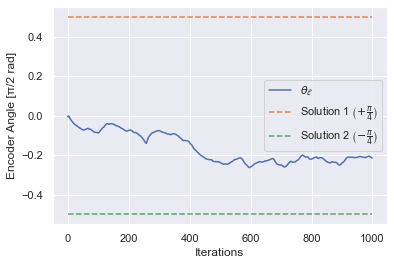

In [81]:
plot_theta(frames, gt_decoder.theta)

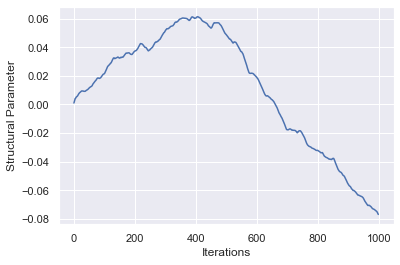

In [82]:
plot_key(frames, 'alpha', name='Structural Parameter')

In [24]:
for a in model_x2y.parameters():
    model_x2y.parameters()[a]

TypeError: 'generator' object is not subscriptable

In [44]:
for a in model_x2y.state_dict():
    print(len(model_x2y.state_dict()[a]))

32
32
10
10
10
10
10
10


In [48]:
X = opt.TRANS_DISTRY()
l = torch.sum(model_x2y(X)[0] + model_x2y(X)[1] + model_x2y(X)[2])
gr = torch.autograd.grad(l, model_x2y.parameters())

In [50]:
fast_weights = list(map(lambda p: p[1] - 0.1 * p[0], zip(gr, model_x2y.parameters())))

In [51]:
fast_weights

[tensor([[-2.8878],
         [-3.9136],
         [-2.0106],
         [-0.2050],
         [-2.9997],
         [-2.1859],
         [-4.3212],
         [-5.3608],
         [-1.7214],
         [-3.4747],
         [-2.2514],
         [-4.0393],
         [-2.9937],
         [-2.1471],
         [-4.1679],
         [-1.3037],
         [-4.1961],
         [-2.2378],
         [-3.5110],
         [-2.5216],
         [-1.8823],
         [-3.4375],
         [-3.3327],
         [-2.1252],
         [-2.6781],
         [-2.1732],
         [-3.4835],
         [-2.6535],
         [-4.3549],
         [-2.4402],
         [-3.4757],
         [-2.4004]], grad_fn=<SubBackward0>),
 tensor([ -2.8629,  -2.3016,   3.6327,  -1.4609,   8.8754,  -6.9528,   3.5123,
           5.6219,  -2.3237,  -8.0014,  -4.8660,  -2.0620,   4.6585,   1.6032,
           6.3318,  -2.8193,   1.0724,  -0.6658,  -2.7023,   4.4096,  -3.6348,
           1.8922,  -1.6488,   2.1224,  -6.3417,   0.7289, -14.8928,  -1.4936,
          -6.5847,

In [53]:
for a in model_x2y.parameters():
    print(a)

Parameter containing:
tensor([[-3.3143],
        [-3.8699],
        [-2.8731],
        [-2.1916],
        [-2.4429],
        [-2.6284],
        [-3.9349],
        [-3.9627],
        [-2.1905],
        [-3.0306],
        [-3.3344],
        [-3.7735],
        [-3.7719],
        [-2.0121],
        [-3.8052],
        [-2.0713],
        [-3.9605],
        [-2.1196],
        [-2.3579],
        [-2.7435],
        [-2.4334],
        [-3.2530],
        [-3.1166],
        [-2.9213],
        [-3.7633],
        [-2.7936],
        [-2.9195],
        [-3.0377],
        [-2.3461],
        [-3.4923],
        [-3.7965],
        [-3.1126]], requires_grad=True)
Parameter containing:
tensor([ 0.1201, -0.3152,  0.9722, -0.1836, -0.2048,  0.1278, -0.4059, -0.7859,
        -0.7780,  0.1294, -0.6606, -0.1219,  0.6094, -0.4686, -0.3270, -0.0654,
        -0.4910,  0.3606,  0.9832, -0.1897,  0.0070, -0.7274,  0.5113,  0.4754,
        -0.6498,  0.9814,  0.2270, -0.1068,  0.6186, -0.3197,  0.2161,  0.7961],
      

In [55]:
{x: y for x, y in zip(list(model_x2y.state_dict().keys()), fast_weights)}

{'z_h.0.weight': tensor([[-2.8878],
         [-3.9136],
         [-2.0106],
         [-0.2050],
         [-2.9997],
         [-2.1859],
         [-4.3212],
         [-5.3608],
         [-1.7214],
         [-3.4747],
         [-2.2514],
         [-4.0393],
         [-2.9937],
         [-2.1471],
         [-4.1679],
         [-1.3037],
         [-4.1961],
         [-2.2378],
         [-3.5110],
         [-2.5216],
         [-1.8823],
         [-3.4375],
         [-3.3327],
         [-2.1252],
         [-2.6781],
         [-2.1732],
         [-3.4835],
         [-2.6535],
         [-4.3549],
         [-2.4402],
         [-3.4757],
         [-2.4004]], grad_fn=<SubBackward0>),
 'z_h.0.bias': tensor([ -2.8629,  -2.3016,   3.6327,  -1.4609,   8.8754,  -6.9528,   3.5123,
           5.6219,  -2.3237,  -8.0014,  -4.8660,  -2.0620,   4.6585,   1.6032,
           6.3318,  -2.8193,   1.0724,  -0.6658,  -2.7023,   4.4096,  -3.6348,
           1.8922,  -1.6488,   2.1224,  -6.3417,   0.7289, -14.8928

In [56]:
model_x2y.load_state_dict({x: y for x, y in zip(list(model_x2y.state_dict().keys()), fast_weights)})

In [57]:
model_x2y

MDN(
  (z_h): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
  )
  (z_pi): Linear(in_features=32, out_features=10, bias=True)
  (z_mu): Linear(in_features=32, out_features=10, bias=True)
  (z_sigma): Linear(in_features=32, out_features=10, bias=True)
)

In [60]:
a = normal(3, 2, 50)
a[:25, :]

tensor([[ 7.7236],
        [ 3.7986],
        [ 1.5527],
        [ 4.4334],
        [ 2.2987],
        [ 0.4952],
        [ 0.4673],
        [ 3.2789],
        [ 1.0443],
        [ 7.3633],
        [ 5.3059],
        [ 1.4255],
        [ 2.8367],
        [ 5.1099],
        [ 2.6713],
        [ 3.1380],
        [-1.4487],
        [ 5.5852],
        [ 5.4335],
        [ 2.5612],
        [ 6.9069],
        [ 3.1094],
        [ 2.5294],
        [ 0.4122],
        [ 3.8993]])